<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/class_truncated_double_exponential_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyro-ppl=='1.8.0'

     |████████████████████████████████| 713 kB 5.2 MB/s 


modeled on: 
- https://github.com/pyro-ppl/pyro/blob/dev/pyro/distributions/multivariate_studentt.py
- https://github.com/pyro-ppl/pyro/blob/dev/pyro/distributions/logistic.py
- https://github.com/pyro-ppl/pyro/blob/dev/pyro/distributions/inverse_gamma.py
- https://stats.stackexchange.com/questions/508749/generating-random-samples-obeying-the-exponential-distribution-with-a-given-min

In [7]:
from pyro.distributions.torch import Exponential, TransformedDistribution
import pyro.distributions as dist
import torch
import seaborn as sns


expdist = Exponential(rate=0.1)
cdf = expdist.cdf
icdf = expdist.icdf
u_samples = dist.Uniform(0,1).sample([1000])
exp_samples = expdist.sample([1000])

a,b = torch.tensor([0]), torch.tensor([torch.inf])

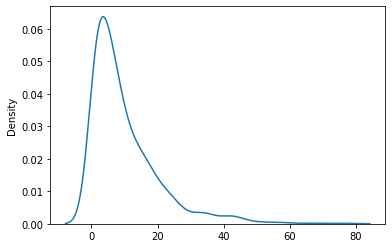

In [8]:
trunc = icdf(cdf(a) + (cdf(b)-cdf(a))*u_samples)
sns.kdeplot(data=exp_samples)

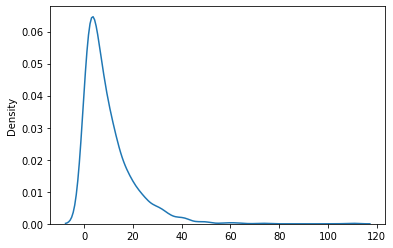

In [9]:
sns.kdeplot(data=trunc)

In [16]:
from pyro.distributions.torch import Exponential, TransformedDistribution
import pyro.distributions as dist
import torch
import seaborn as sns
import pandas as pd
import numpy as np

def trunc_exp(rate, low,high, num_samples=1000):
  expdist = Exponential(rate=rate)
  assert low >= 0, "low must be >= 0"
  assert high > low, "high must be > low"
  u = dist.Uniform(0,1).sample([num_samples])
  a = torch.tensor([low])
  b = torch.tensor([high])
  return expdist.icdf(expdist.cdf(a) + (expdist.cdf(b)-expdist.cdf(a))*u_samples)



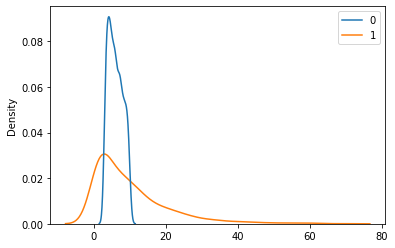

In [17]:
rate = 0.1
a, b = 3., 10.

x1 = trunc_exp(rate, a,b)
x2 = Exponential(rate).sample([1000])

out = np.stack([x1,x2], axis=1)
sns.kdeplot(data=out);

In [20]:
print(x1.grad)

None


In [24]:
from pyro.distributions.torch import Exponential, TransformedDistribution
import pyro.distributions as dist
import torch
import seaborn as sns
import pandas as pd
import numpy as np


def trunc_exp_2(rate, low,high, num_samples=1000):
  expdist = Exponential(rate=rate)
  assert low >= 0, "low must be >= 0"
  assert high > low, "high must be > low"
  a = expdist.cdf(torch.tensor([low]))
  b = expdist.cdf(torch.tensor([high]))
  u = dist.Uniform(a,b).sample([num_samples])
  return expdist.icdf(u)

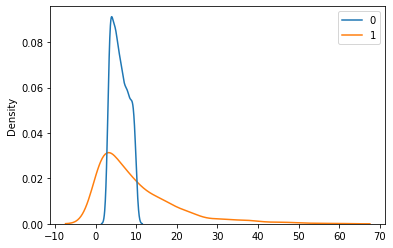

In [27]:
rate = 0.1
a, b = 3., 10.

x1 = trunc_exp_2(rate, a,b).squeeze()
x2 = Exponential(rate).sample([1000])

x1.size(), x2.size()
out = np.stack([x1,x2], axis=1)
sns.kdeplot(data=out);

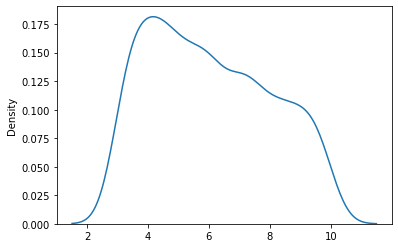

In [14]:
sns.kdeplot(data=trunc_exp(0.1, 3,10))

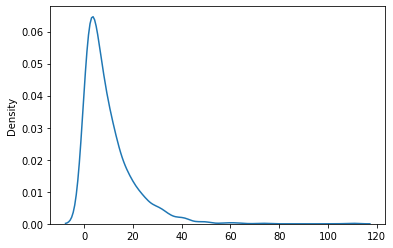

In [15]:
sns.kdeplot(data=trunc_exp(0.1, 0, torch.inf))

#
# Provide a CDF and its percentage point function.
#
lambda <- 1/2
ff <- function(x) pexp(x, lambda)
f.inv <- function(q) qexp(q, lambda)
#
# Specify the interval of truncation.
#
a <- 2
b <- 7
#
# Simulate data and truncated data.
#
n <- 1e6
x <- f.inv(runif(n))
x.trunc <- f.inv(runif(n, ff(a), ff(b)))
#
# Draw histograms.
#
dx <- (b - a) / 25
bins <- seq(a - ceiling((a - min(x))/dx)*dx, max(x)+dx, by=dx)

h <- hist(x.trunc, breaks=bins, plot=FALSE)
hist(x, breaks=bins, freq=FALSE, ylim=c(0, max(h$density)), col="#e0e0e0",
     xlab="Value", 
     main="Histogram of X and its truncated version")
plot(h, add=TRUE, freq=FALSE, col="#2020ff40")

abline(v = c(a,b), lty=3, lwd=2)
mtext(c(expression(a), expression(b)), at = c(a, b), side=1, line=0.25)

In [ ]:
import math

import torch
from torch.distributions import constraints
from torch.distributions.utils import lazy_property
from torch.distributions.transforms import AffineTransform, ExpTransform

from pyro.distributions.torch import Exponential, TransformedDistribution
from pyro.distributions.torch_distribution import TorchDistribution
from pyro.distributions.util import broadcast_shape, broadcast_all

In [ ]:
# Do this using transformed distribution, like in inverse gamma case
class TruncatedExponential(TransformedDistribution):
  """
    Creates a Double truncated Exponential parameterized by 
    rate :attr:`rate`, lower bound :attr:`low` and upper bound :attr:`high`
    so that the exponential pdf is defined only on the range (low, high)
    with low >0 and high > low > 0
   
    :param ~torch.Tensor rate: rate of Exponential distribution
    :param ~torch.Tensor low: lower bound of the distribution (low > 0)
    :param ~torch.Tensor high: upper bound of the distribution (high > low > 0)
  """

  has_rsample = True #flip to False if I cannot implement rsample successfully

  ##TODO where do I impose constraint low < high. Tried to implement as support per https://github.com/pyro-ppl/pyro/blob/dev/pyro/distributions/affine_beta.py
  arg_constraints = {
      "rate": constraints.positive,
      "low": constraints.positive,
      "high": constraints.positive,
  }

  def __init__(self, rate, low=torch.tensor([0.]), high=torch.tensor([torch.inf]), validate_args=None):
    base_dist = Exponential(rate)
    super().__init__(base_dist,
                     [AffineTransform()], ##TODO FIX THIS
                     validate_args=validate_args
        )

  def expand(self, batch_shape, _instance=None):
    new = self._get_checked_instance(TruncatedExponential, _instance)
    return super().expand(batch_shape, _instance=new)

  @property
  def rate(self):
    return self.base_dist.rate
  
  def rsample(self, sample_shape=torch.Size()):
    shape = self._extended_shape(sample_shape)
    raise NotImplementedError("sample has not been implemented")
  
  def log_prob(self, value):
    if self._validate_args: self._validate_sample(value)
    raise NotImplementedError("log_prob has not been implemented")

  def cdf(self, value):
    if self._validate_args: self._validate_sample(value)
    raise NotImplementedError("cdf has not been implemented")

  def icdf(self, value):
    if self._validate_args: self._validate_sample(value)
    raise NotImplementedError("icdf has not been implemented")

  def expand(self, batch_shape, _instance=None):
    new = self._get_checked_instance(TruncatedExponential, _instance)
    batch_shape = torch.Size(batch_shape)
    new.loc = self.loc.expand(batch_shape)
    new.scale = self.scale.expand(batch_shape)
    super(TruncatedExponential, new).__init__(batch_shape, validate_args=False)
    new._validate_args = self._validate_args
    return new

  # following https://github.com/pyro-ppl/pyro/blob/dev/pyro/distributions/affine_beta.py but is that only for integers??
  @constraints.dependent_property
  def support(self):
      return constraints.interval(self.low, self.high)